In [3]:
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import os
from util import *
import torch
from scipy.io import loadmat

In [4]:
def load_noel_data(data_path_root, group_id, block_id_val):
    """
    Loads Noel et al. (2021) data for a specific group and block.
    """
    print(f"Loading data from root: {data_path_root} for Group ID: {group_id}, Block ID: {block_id_val}")

    stimuli_list = []
    responses_list = []
    subject_ids_list_collector = [] # To collect numerical subject IDs
    block_ids_list_collector = []

    if group_id == 1: # ASD
        group_name_folder = "ASD"
        subject_prefix = "A"
        num_subjects = 17
    elif group_id == 0: # TD (Neurotypical)
        group_name_folder = "TD"
        subject_prefix = "H"
        num_subjects = 25
    else:
        raise ValueError("group_id must be 0 (TD) or 1 (ASD)")

    if block_id_val == 0:
        block_name_folder = "woFB"
        block_name_short_in_file = "woFB"
    elif block_id_val == 1:
        block_name_folder = "wFB1"
        block_name_short_in_file = "wFB1"
    elif block_id_val == 2:
        block_name_folder = "wFB2"
        block_name_short_in_file = "wFB2"
    else:
        raise ValueError("block_id_val must be 0 (woFB), 1 (wFB1), or 2 (wFB2)")

    # !!! IMPORTANT: Adjust this key to the actual variable name in your .mat files !!!
    mat_data_key = 'all_data' # Common placeholder, check your .mat files

    files_found_count = 0
    for i_subj in range(1, num_subjects + 1):
        subject_id_str = f"{subject_prefix}{i_subj}"
        filename = f"{subject_id_str}{block_name_short_in_file}.mat"
        filepath = os.path.join(data_path_root, block_name_folder, group_name_folder, filename)

        if os.path.exists(filepath):
            files_found_count +=1
            try:
                mat_data = loadmat(filepath)
                if mat_data_key not in mat_data:
                    print(f"ERROR: Key '{mat_data_key}' not found in {filepath}. Available keys: {list(mat_data.keys())}")
                    continue

                data_array = mat_data[mat_data_key]
                if data_array.shape[0] != 2:
                    print(f"ERROR: Data in {filepath} does not have 2 rows (shape: {data_array.shape}). Skipping.")
                    continue
                
                targets = data_array[0, :].astype(np.float32) # First row: target
                responses = data_array[1, :].astype(np.float32) # Second row: response
                num_trials = targets.shape[0]

                stimuli_list.append(torch.from_numpy(targets))
                responses_list.append(torch.from_numpy(responses))
                subject_ids_list_collector.append(torch.full((num_trials,), i_subj, dtype=torch.long)) # Use numerical subject ID
                block_ids_list_collector.append(torch.full((num_trials,), block_id_val, dtype=torch.long))

            except Exception as e:
                print(f"Error loading or processing file {filepath}: {e}")
        else:
            print(f"Warning: File not found {filepath}")

    if not stimuli_list:
        raise FileNotFoundError(f"No data files successfully loaded for Group: {group_name_folder}, Block: {block_name_folder}. Files found: {files_found_count}")

    all_stimuli = ToDevice(torch.cat(stimuli_list))
    all_responses = ToDevice(torch.cat(responses_list))
    all_subject_ids = ToDevice(torch.cat(subject_ids_list_collector))
    all_block_ids = ToDevice(torch.cat(block_ids_list_collector))
    
    print(f"Successfully loaded {all_stimuli.shape[0]} trials for {files_found_count} subjects.")
    return all_stimuli, all_responses, all_subject_ids, all_block_ids


In [11]:
DATA_ROOT_PATH = 'F:\\Courses2025\\认知建模基础\\ASD_Encoding_2020'
GROUP_ID = 0     # ASD
BLOCK_ID_VAL = 0  # wFB1
P_VAL = 2         # L2 loss (posterior mean)
FOLD_HERE = 2
REG_WEIGHT = 0.01
GRID_SIZE = 60    # GR60
DEVICE = 'cpu'    # Always load to CPU for analysis portability

In [12]:
observations_x, observations_y, subject_ids, block_ids = load_noel_data(DATA_ROOT_PATH, GROUP_ID, BLOCK_ID_VAL)

Loading data from root: F:\Courses2025\认知建模基础\ASD_Encoding_2020 for Group ID: 0, Block ID: 0
Successfully loaded 4900 trials for 25 subjects.


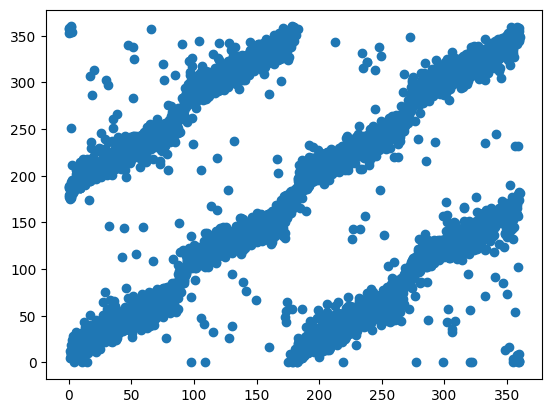

In [13]:
plt.scatter(observations_x, observations_y)

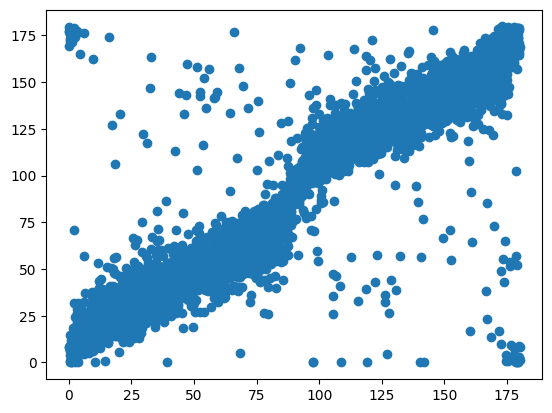

In [14]:
observations_x_180 = observations_x%180
observations_y_180 = observations_y%180
plt.scatter(observations_x_180, observations_y_180)

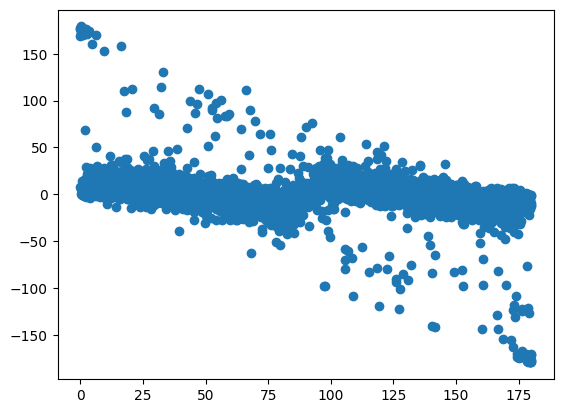

In [18]:
bias = observations_y_180 - observations_x_180
#bias = bias%180
plt.scatter(observations_x_180,bias)